# Introduction Catenoid principal curvatures

The purpose of this notebook is to investigate numerical formulas for the integrated principal curvatures of discretised surfaces by comparing it to the test case of a Catenoid with an analytical solution in the form of a parametric surface function.

In [1]:
import os, sys
import math
print(os.getcwd())
print(os.getcwd()+"/ddgclib")
sys.path.append(os.getcwd()+"/ddgclib")
os.chdir(os.getcwd())
import ddgclib

import polyscope as ps
from ddgclib._plotting import *
from ddgclib._curvatures import *
import numpy as np
from ddgclib._catenoid_clean import *
module_path = os.path.abspath(os.path.join('..'))
import matplotlib.pyplot as plt
if module_path not in sys.path:
    sys.path.append(module_path)
    
def cut_y_plane(HC):
    """
    Cuts a y-plane out of the complex to visualise.
    
    :param HC: Complex object 
    :return: Sorted list of vertices in the cut out plane.
    """
    d = 2*c
    vlist = []
    vlist_x = []
    
    for v in HC.V:
        if (abs(v.x[0]) <= 1e-8) and (0.0 <= v.x[1] <= d):
            vlist.append(v)
    
    
    for v in vlist:
        #print(v.x)
        vlist_x.append(v.x)
        #print(type(v.x))
    
    sorted_list = sorted(vlist_x, key=lambda x: x[-1])
    # Ausgabe der sortierten Liste
    #print("Sorted list according to the last element in each tuple:")
    #for tupel in sorted_list:
    #    print(tupel)
    return sorted_list




/home/stefan_endres/projects/ddg/ddgclib
/home/stefan_endres/projects/ddg/ddgclib/ddgclib


## Define the known analytical values of the Catenoid bridge

The parameterised Catenoid function is defined as (code function `catenoid` imported from _catenoid_clean.py)

$$
\begin{aligned}
& x=c \cosh \left(\frac{v}{c}\right) \cos u \\
& y=c \cosh \left(\frac{v}{c}\right) \sin u \\
& z=v,
\end{aligned}
$$
where $u \in[0,2 \pi)$. And $c$ is an arbitary parameter.

The principal curvatures are
$$
\begin{aligned}
\kappa_1 & =\frac{1}{c} \operatorname{sech}^2\left(\frac{v}{c}\right) \\
\kappa_2 & =-\frac{1}{c} \operatorname{sech}^2\left(\frac{v}{c}\right) .
\end{aligned}
$$

The mean curvature of the catenoid is
$$
H= \kappa_1 + \kappa_2 = 0
$$

and the Gaussian curvature is
$$
K=-\frac{1}{c^2} \operatorname{sech}^4\left(\frac{v}{c}\right) .
$$

The analytical functions are implemented in the python code below:

In [2]:
# Define kappa_1 in terms of v and c (by rotational symmetry it is the same for all u \in [0, 2 pi])
def fun_kappa1(v, c):
    kappa_1 = (1/c) *(sech(v/c))**2
    return kappa_1

def fun_kappa2(c, v):
    kappa_2 = -1/c *sech(v/c)**2
    return kappa_2

def gaussian_curvature_catenoid(v, c):
    '''
    Analytical Solution for gaussian curvature
    '''
    return -1/c**2 * sech(v/c)**4

def gaussian_curvature(kappa1, kappa2):
    K = kappa1 * kappa2
    return K

def mean_curvature(kappa1, kappa2):
    return kappa1 + kappa2


v = 0.5
c = 1


In [61]:
import numpy as np

def catenoid(u, v, c):
    x = c * np.cos(u) * np.cosh(v / c)
    y = c * np.sin(u) * np.cosh(v / c)
    z = v
    return x, y, z

def catenoid_normal_vector(u, v, c):
    du = 1e-5  # small change in u for numerical derivative
    dv = 1e-5  # small change in v for numerical derivative

    # Calculate partial derivatives
    X_u = (np.array(catenoid(u + du, v, c)) - np.array(catenoid(u - du, v, c))) / (2 * du)
    X_v = (np.array(catenoid(u, v + dv, c)) - np.array(catenoid(u, v - dv, c))) / (2 * dv)

    # Cross product and normalization
    cross_product = np.cross(X_u, X_v)
    normalized_vector = cross_product / np.linalg.norm(cross_product)

    return normalized_vector


def n(u, v, c):
    return [c*math.cos(u)*math.cosh(v/c)/math.sqrt((1/4)*abs(c*math.sinh(2*v/c))**2 + abs(c*math.sin(u)*math.cosh(v/c))**2 + abs(c*math.cos(u)*math.cosh(v/c))**2)], [c*math.sin(u)*math.cosh(v/c)/math.sqrt((1/4)*abs(c*math.sinh(2*v/c))**2 + abs(c*math.sin(u)*math.cosh(v/c))**2 + abs(c*math.cos(u)*math.cosh(v/c))**2)], [-c*math.sinh(2*v/c)/math.sqrt(abs(c*math.sinh(2*v/c))**2 + 4*abs(c*math.sin(u)*math.cosh(v/c))**2 + 4*abs(c*math.cos(u)*math.cosh(v/c))**2)]

# Example usage:
u_value = np.pi/2
v_value = 0.5
c_value = 1.0
normal_at_uv = catenoid_normal_vector(u_value, v_value, c_value)

print("Normal Vector at (u={}, v={}): {}".format(u_value, v_value, normal_at_uv))

Normal Vector at (u=1.5707963267948966, v=0.5): [ 0.          0.88681888 -0.46211716]


## Find integrated values

Next we try to find the integrated solutions of the analytical functions in order to find a good comparison with a numerical formulation.

First, it can be seen that unfortunately an attempt to find a closed form solution with sympy fails: 

In [4]:
from sympy import symbols, integrate#, sech
import sympy as sp

# Define symbols and parameters
v, c = symbols('v c')

# Define kappa_1 in terms of v and c
kappa_1 = 1 / c * sp.sech(v / c)**2
#kappa_1 = 1 / c * 1/sp.cosh(v / c)**2

# Define the integration bounds for v
v_min = 0.1  # replace with the lower bound of the domain
v_max = 0.2  # replace with the upper bound of the domain

# Integrate kappa_1 with respect to v over the given domain
integrated_kappa_1 = integrate(kappa_1, (v, v_min, v_max)).evalf()

# Display the result
print("Integrated kappa_1 over the domain:", integrated_kappa_1)

Integrated kappa_1 over the domain: Integral(sech(v/c)**2, (v, 0.1, 0.2))/c


### Numerical intergration

Next we find the numerical integral of `kappa_1_integrand(v, c)`.

Note that there are two possibilities, dotted with the normal vector $N$ or without. First we will investigate with the normal vector, therefore the rountine below solves the definite example integral

$$
\int^{v_{max} = 0}_{v_{min} = -1} \kappa_1(v, c) \cdot N(v, c) dv
$$

#### Function for $\kappa_1(v, c)$
First we define an integratable function $\kappa_1(v, c)$:

In [5]:
from scipy.integrate import quad
import numpy as np

# Define the integrand function    
def kappa_1_integrand(v, c):  # Slightly higher accuracy of the same function func_kappa1 above
    return (1 / c) * np.power(sech(v / c), 2)

# Define the integration bounds for v
v_min = -1.0  # replace with the lower bound of the domain
v_max = 0.0   # replace with the upper bound of the domain

# Numerically integrate the function over the specified domain
c = 1.0
result, error = quad(kappa_1_integrand, v_min, v_max, args=(c))

# Display the numerical result
print("Numerical result of the integrated kappa_1 over the domain:", result)

Numerical result of the integrated kappa_1 over the domain: 0.7615941559557649


#### Normal vectors

Next we define an integratable function $N(v, c)$.

In [111]:
def N_func(v, u, c):
    return np.array([c*math.cos(u)*math.cosh(v/c)/math.sqrt((1/4)*abs(c*math.sinh(2*v/c))**2 + abs(c*math.sin(u)*math.cosh(v/c))**2 + abs(c*math.cos(u)*math.cosh(v/c))**2),                          c*math.sin(u)*math.cosh(v/c)/math.sqrt((1/4)*abs(c*math.sinh(2*v/c))**2 + abs(c*math.sin(u)*math.cosh(v/c))**2 + abs(c*math.cos(u)*math.cosh(v/c))**2), -                        c*math.sinh(2*v/c)/math.sqrt(abs(c*math.sinh(2*v/c))**2 + 4*abs(c*math.sin(u)*math.cosh(v/c))**2 + 4*abs(c*math.cos(u)*math.cosh(v/c))**2)])


# For when u is a constant:
c = 1.0
u = np.pi/2
v = 0.5
v_min, v_max, u, c, N_func(v, u, c), n(u, v, c), np.linalg.norm(N_func(v, u, c))

(-0.5,
 0.5,
 1.5707963267948966,
 1.0,
 array([ 5.43019954e-17,  8.86818884e-01, -4.62117157e-01]),
 ([5.430199538386895e-17], [0.8868188839700739], [-0.46211715726000974]),
 1.0)

In [112]:
from scipy.integrate import quad
import numpy as np

c = 1
u = np.pi / 2

#def N_func(v, u, c):
#    return np.array([c**2 * np.cos(u) * np.cosh(v / c),
#                     c**2 * np.sin(u) * np.cosh(v / c),
#                     c * (np.sin(u)**2 * np.tanh(v / c) + np.cos(u)**2 * np.tanh(v / c)) * np.cosh(v / c)**2])

# Define the integration bounds for v
v_min = -1.0  # replace with the lower bound of the domain
v_max = 0.0   # replace with the upper bound of the domain

# Numerically integrate each component of the vector along the x=0 plane
result_N_x, error_N_x = quad(lambda v: N_func(v, u, c)[0], v_min, v_max)
result_N_y, error_N_y = quad(lambda v: N_func(v, u, c)[1], v_min, v_max)
result_N_z, error_N_z = quad(lambda v: N_func(v, u, c)[2], v_min, v_max)

print("Numerical result for N_x along x=0 plane:", result_N_x)
print("Error estimate for N_x along x=0 plane:", error_N_x)

print("Numerical result for N_y along x=0 plane:", result_N_y)
print("Error estimate for N_y along x=0 plane:", error_N_y)

print("Numerical result for N_z along x=0 plane:", result_N_z)
print("Error estimate for N_z along x=0 plane:", error_N_z)

Numerical result for N_x along x=0 plane: 5.30130913224453e-17
Error estimate for N_x along x=0 plane: 5.885635459273487e-31
Numerical result for N_y along x=0 plane: 0.8657694832396586
Error estimate for N_y along x=0 plane: 9.611972143104926e-15
Numerical result for N_z along x=0 plane: 0.4337808304830271
Error estimate for N_z along x=0 plane: 4.815934656432787e-15


#### Combined integral

In [129]:
def kN(v, u, c):
    N = N_func(v, u, c)  
    kappa_1 = kappa_1_integrand(v, c)
    print(N)
    return np.array([N[0] * kappa_1,
                     N[1] * kappa_1,
                     N[2] * kappa_1])

# Define the integration bounds for v
v_min = -0.5  # replace with the lower bound of the domain
v_max = 0.5  # replace with the upper bound of the domain

def int_kN(v_min, v_max, u, c):
    # Numerically integrate each component of the vector along the x=0 plane
    result_kN_x, error_N_x = quad(lambda v: N_func(v, u, c)[0], v_min, v_max)
    result_kN_y, error_N_y = quad(lambda v: N_func(v, u, c)[1], v_min, v_max)
    result_kN_z, error_N_z = quad(lambda v: N_func(v, u, c)[2], v_min, v_max)
    return result_kN_x, result_kN_y, result_kN_z

result_kN_x, result_kN_y, result_kN_z = int_kN(v_min, v_max, u, c)
int_kN(v_min, v_max, u, c)

(5.882971509320732e-17, 0.9607621582674589, 0.0)

#### Generate the Catenoid function as a complex and extract the profile of the bridge

In [114]:
import numpy as np

# Define catenoid parametric equations
def catenoid(u, v, c):
    x = c * np.cos(u) * np.cosh(v / c)
    y = c * np.sin(u) * np.cosh(v / c)
    z = v
    return x, y, z

# Function to compute tangent vectors numerically
def compute_tangent_vectors(u, v, c, delta=1e-5):
    # Calculate points on the surface
    points = np.array(catenoid(u, v, c)).T

    # Perturb u and v to compute tangent vectors
    perturbed_u = u + delta
    perturbed_v = v + delta

    perturbed_points_u = np.array(catenoid(perturbed_u, v, c)).T
    perturbed_points_v = np.array(catenoid(u, perturbed_v, c)).T

    # Numerical differentiation to compute tangent vectors
    tangent_vector_u = (perturbed_points_u - points) / delta
    tangent_vector_v = (perturbed_points_v - points) / delta

    return tangent_vector_u, tangent_vector_v

# Example usage:
u_values = np.linspace(0, 2 * np.pi, 20)
v_values = np.linspace(-1, 1, 20)
c_value = 1.0

# Compute tangent vectors at specific u and v values
u_mesh, v_mesh = np.meshgrid(u_values, v_values)
u = np.pi / 2 
v = 0.0
tangent_u, tangent_v = compute_tangent_vectors(u, v, c_value)

# Print or visualize the tangent vectors as needed
tangent_u, tangent_v  # We only care about tangent v for now?

(array([-1.00000000e+00, -5.00000041e-06,  0.00000000e+00]),
 array([3.06161848e-22, 5.00000041e-06, 1.00000000e+00]))

n_i(-1.0 = [3.96818796e-17 6.48054274e-01 7.61594156e-01]
tangent_v = [-7.19598466e-17 -1.17519348e+00  1.00000000e+00]
 dotted = 4.99998730603559e-06
 norm = 1.0
n_i(-0.5 = [5.43019954e-17 8.86818884e-01 4.62117157e-01]
tangent_v = [-3.19075397e-17 -5.21089667e-01  1.00000000e+00]
 dotted = 4.999992293457686e-06
 norm = 1.0
n_i(0.0 = [ 6.123234e-17  1.000000e+00 -0.000000e+00]
tangent_v = [3.061617e-22 5.000000e-06 1.000000e+00]
 dotted = 5.0000000017050295e-06
 norm = 1.0
n_i(0.5 = [ 5.43019954e-17  8.86818884e-01 -4.62117157e-01]
tangent_v = [3.19082301e-17 5.21100944e-01 1.00000000e+00]
 dotted = 5.000007699986278e-06
 norm = 1.0
n_i(1.0 = [ 3.96818796e-17  6.48054274e-01 -7.61594156e-01]
tangent_v = [7.19607914e-17 1.17520891e+00 1.00000000e+00]
 dotted = 5.000012688507105e-06
 norm = 1.0


Text(0.5, 0, 'y')

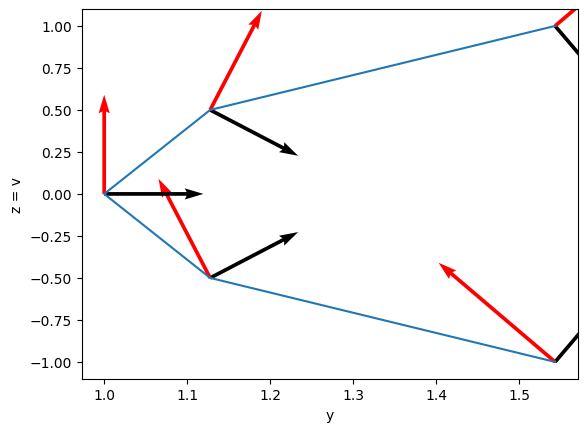

In [120]:
# Global parameters
c = 1
u = np.pi / 2  # This corresponds to the x=0 plane
length = 2
HC, bV, K_f, H_f, neck_verts, neck_sols = catenoid_clean_N(c, length, refinement=2)
#plot_polyscope(HC)

yplane = cut_y_plane(HC)
xvals = []
yvals = []
plt.figure()
for vertex in yplane:   
    #print(f'vertex = {vertex[0]}')
    yvals.append(vertex[2])
    xvals.append(vertex[1])
    v_val = vertex[2]
    n_i = N_func(v_val, u, c)  # N_func(v, u, c)
    print(f'n_i({v_val} = {n_i}')
    tangent_u, tangent_v = compute_tangent_vectors(u, v_val, c)
    n_io = copy.copy(n_i)
    print(f'tangent_v = {tangent_v}')
    print(f' dotted = {np.dot(tangent_v, n_i)}')
    print(f' norm = {np.linalg.norm(n_i)}')
    n_i[1]
    # quiver([X, Y], U, V,
    plt.quiver(vertex[1], vertex[2], n_i[1], n_i[2] , scale=5, color='black')
    plt.quiver(vertex[1], vertex[2], tangent_v[1], tangent_v[2], scale=5, color='red')
    

plt.plot(xvals, yvals)
plt.ylabel('z = v')
plt.xlabel('y')

# Formulations
### Neck symmetry

First we confirm that the integral of the curvature normal $\int^{v_max}_{v_min} kN dv$ around the $v=0$ is also zero, Note here that for now we only care aboute the curvature in the z-plane direction, that is `result_kN_z` below:

In [198]:
# Define the integration bounds for v
v_min = -0.5  # replace with the lower bound of the domain
v_max = 0.5  # replace with the upper bound of the domain

# Compute the integral
result_kN_x, result_kN_y, result_kN_z = int_kN(v_min, v_max, u, c)
result_kN_x, result_kN_y, result_kN_z

(5.882971509320732e-17, 0.9607621582674589, 0.0)

#### DDG

First we attempt to compare with the $z$ component of the integral on an edge $*df = \frac{1}{e_{ij}} (f_j - f_i)$

In [222]:
v0 = np.array(yplane[0])  # The boundary vertex i
v1 = np.array(yplane[1])  # The connected vertex j
v2 = np.array(yplane[2])  # The central vertex
v3 = np.array(yplane[3])
v0[1], v1[1], v2[1]

(1.5430806348152437785, 1.1276259652063807853, 1.0)

HNdA_i, HNdA_i_Ci[2]
### Boundary vertex:

Next we check the integral around the boundary

In [239]:
# First check the boundary vertex:

e_ij = np.linalg.norm(v1 - v0)
1/e_ij * (v1  - v0) / 2

array([-1.95662876e-17, -3.19541725e-01,  3.84568701e-01], dtype=float128)

In [224]:
# Compare to the integral
v_min = -1.0  # replace with the lower bound of the domain
v_max = -0.5  # replace with the upper bound of the domain

# Compute the integral
int_kN(v_min, v_max, u, c)

(2.3598233775841646e-17, 0.38538840410592917, 0.31366632352474966)

In [255]:
vert_0 = HC.V[yplane[0]]  # kappa_1 = 0.419974341614026069
FF, nn = vectorise_vnn(vert_0)
cdict = b_curvatures_hn_ij_c_ij(FF, nn)
HNdA_i = cdict['HNdA_i']
HNdA_i_Ci = HNdA_i/cdict['C_i']
HNdA_i, HNdA_i_Ci[2]

(array([-2.30935063e-17, -3.75722151e-01,  1.58071335e+00], dtype=float128),
 0.50906724644692817025)

#### Centre

Integral around the center vertex

In [256]:
# Compare to the integral
v_min = -0.5  # replace with the lower bound of the domain
v_max = 0.5  # replace with the upper bound of the domain


# Compute the integral
int_kN(v_min, v_max, u, c)

(5.882971509320732e-17, 0.9607621582674589, 0.0)

In [257]:
e_ij = np.linalg.norm(v1 - v2)
e_ik = np.linalg.norm(v3 - v2)
1/e_ij * (v1  - v2)  + 1/e_ik * (v3  - v2)  

array([-0.66420019,  1.05767441,  0.81253313])

#### Question, the result below produces :

In [258]:
1/e_ij * (v1  - v2) 

array([0.16486361, 0.49979778, 0.8503071 ])

Is the -9.68933320e-01 related to the integral output of 0.9607621582674589? which is relatable to the boundary condition?

## Idea based on mean normal curvature results

Can we use the definition $H= \kappa_1 + \kappa_2 $ as well as the orthoganol condition to derive equations from the working dual integral?


$$
d*df =  \int H N dA = \int (\kappa_1 + \kappa_2) N dA
$$

Where unit vectors in the direction of the principal curvatures $X_1$, $X_2$:

$$ \kappa_1 X_1  \cdot \kappa_2 X_2 = 0 $$

so decomposing the $d*df$ vector could produce $X_1$ and $X_2$ and then we could kind the principal curvatures? First let's get the mean curvature around the centre vertex back:

In [259]:
vert_0 = HC.V[yplane[2]]  # kappa_1 = 0.419974341614026069
FF, nn = vectorise_vnn(vert_0)
cdict = b_curvatures_hn_ij_c_ij(FF, nn)
HNdA_i = cdict['HNdA_i']
HNdA_i_Ci = HNdA_i/cdict['C_i']
HNdA_i, HNdA_i_Ci[2]

(array([2.05998413e-17, 3.39519314e-01, 0.00000000e+00], dtype=float128), 0.0)

Around this vertex on the bridge neck the kappa values and the vectors $X_1$ and $X_2$ are known as they are in the axissymetric directions.

\



![title](kappa_cat.png)

In [262]:
X_1 = np.array([0, 0, 1])  # in the kappa_1 > 0 direction?
X_2 = np.array([0, 1, 0])  # in the kappa_2 < 0 direction
e_ij = np.linalg.norm(v2 - v1)
e_ij

1.000404597021129

It is immediately clear that we need more than one vector if you want the third component to sum to zero. Either the edge vectors should be used instead or the vectors need to be solved using the system of equations.

Maybe using Gram-Schidt decomposition?

In [260]:
import numpy as np

# Define your 3-element vector
vector = np.array([1, 2, 3])

# Create a 3x3 matrix using the vector
matrix = np.diag(vector)

# Calculate the eigenvalues
eigenvalues = np.linalg.eigvals(matrix)

In [241]:
import numpy as np

def gram_schmidt(vectors):
    num_vectors = len(vectors)
    basis = np.zeros_like(vectors)
    
    for i in range(num_vectors):
        basis[i] = vectors[i]
        for j in range(i):
            basis[i] -= np.dot(vectors[i], basis[j]) / np.dot(basis[j], basis[j]) * basis[j]
            
    return basis

# Define your 3-element vector
vector = np.array([1, 2, 3])

# Perform Gram-Schmidt orthogonalization
orthogonal_basis = gram_schmidt([vector])

# Print the result
print("Original Vector:", vector)
print("Orthogonal Decomposition:", orthogonal_basis[0])

Original Vector: [1 2 3]
Orthogonal Decomposition: [1 2 3]


In [242]:
gram_schmidt(HNdA_i)

/tmp/ipykernel_16884/2383806792.py:10: RuntimeWarning: invalid value encountered in scalar divide
  basis[i] -= np.dot(vectors[i], basis[j]) / np.dot(basis[j], basis[j]) * basis[j]


array([-2.30935063e-17,  0.00000000e+00,             nan], dtype=float128)

## Solve a system of equations

In [243]:
import sympy as sp

# Define the symbols
s1, s2, s3 = sp.symbols('s1 s2 s3')
N1, N2, N3 = sp.symbols('N1 N2 N3', real=True, positive=True)
v1 = sp.Matrix([0.3, 0.5, 0.8])
v2 = sp.Matrix([s2 * N2, 0, 0])
v3 = sp.Matrix([0, s3 * N3, 0])

# Conditions
eq1 = sp.Eq(v1, s1 * sp.Matrix([N1, N1, N1]))
eq2 = sp.Eq(v2, s2 * sp.Matrix([N2, 0, 0]))
eq3 = sp.Eq(v3, s3 * sp.Matrix([0, N3, 0]))
eq4 = sp.Eq(s1, s2 + s3)
eq5 = sp.Eq(v2.dot(v3), 0)

# Solve the system of equations
solution = sp.solve([eq1, eq2, eq3, eq4, eq5], [s1, s2, s3, N2, N3])

# Print the solution
print("Solution:")
print("s1 =", solution[s1])
print("s2 =", solution[s2])
print("s3 =", solution[s3])
print("N2 =", solution[N2])
print("N3 =", solution[N3])


Solution:


TypeError: list indices must be integers or slices, not Symbol

In [247]:
solution

[]

In [245]:
import sympy as sp

# Define the symbols
s1, s2, s3 = sp.symbols('s1 s2 s3')
N1, N2, N3 = sp.symbols('N1 N2 N3', real=True, positive=True)
v1 = sp.Matrix([0.3, 0.5, 0.8])
v2 = sp.Matrix([s2 * N2, 0, 0])
v3 = sp.Matrix([0, s3 * N3, 0])

# Additional constraint: s2 = -s3
constraint = sp.Eq(s2, -s3)

# Conditions
eq1 = sp.Eq(v1, s1 * sp.Matrix([N1, N1, N1]))
eq2 = sp.Eq(v2, s2 * sp.Matrix([N2, 0, 0]))
eq3 = sp.Eq(v3, s3 * sp.Matrix([0, N3, 0]))
eq4 = sp.Eq(s1, s2 + s3)
eq5 = sp.Eq(v2.dot(v3), 0)

# Solve the system of equations with the additional constraint
solution = sp.solve([eq1, eq2, eq3, eq4, eq5, constraint], [s1, s2, s3, N2, N3])

# Print the solution
print("Solution:")
print("s1 =", solution[s1])
print("s2 =", solution[s2])
print("s3 =", solution[s3])
print("N2 =", solution[N2])
print("N3 =", solution[N3])



Solution:


TypeError: list indices must be integers or slices, not Symbol

In [246]:
solution

[]

In [248]:
import numpy as np
from scipy.optimize import fsolve

# Define the objective function to represent the system of equations
def objective(variables):
    s1, s2, s3, N2, N3 = variables
    v1 = np.array([0.3, 0.5, 0.8])
    v2 = np.array([s2 * N2, 0, 0])
    v3 = np.array([0, s3 * N3, 0])

    eq1 = v1 - s1 * np.array([N2, N2, N2])
    eq2 = v2 - s2 * np.array([N2, 0, 0])
    eq3 = v3 - s3 * np.array([0, N3, 0])
    eq4 = s1 - (s2 + s3)
    eq5 = np.dot(v2, v3)

    return [eq1[0], eq1[1], eq1[2], eq2[0], eq2[1], eq2[2], eq3[0], eq3[1], eq3[2], eq4, eq5]

# Initial guess
initial_guess = [1, 1, -1, 1, 1]

# Numerical solution using fsolve
solution = fsolve(objective, initial_guess)

# Print the solution
print("Numerical Solution:")
print("s1 =", solution[0])
print("s2 =", solution[1])
print("s3 =", solution[2])
print("N2 =", solution[3])
print("N3 =", solution[4])


TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument 'objective'.Shape should be (5,) but it is (11,).

In [249]:
import numpy as np
from scipy.optimize import fsolve

# Define the objective function to represent the system of equations
def objective(variables):
    s1, s2, s3, N2, N3 = variables
    v1 = np.array([0.3, 0.5, 0.8])
    v2 = np.array([s2 * N2, 0, 0])
    v3 = np.array([0, s3 * N3, 0])

    eq1 = v1 - s1 * np.array([N2, N2, N2])
    eq2 = v2 - s2 * np.array([N2, 0, 0])
    eq3 = v3 - s3 * np.array([0, N3, 0])
    eq4 = s1 - (s2 + s3)
    eq5 = np.dot(v2, v3)

    return np.array([eq1[0], eq1[1], eq1[2], eq2[0], eq2[1], eq2[2], eq3[0], eq3[1], eq3[2], eq4, eq5])

# Initial guess
initial_guess = [1, 1, -1, 1, 1]

# Numerical solution using fsolve
solution = fsolve(objective, initial_guess)

# Print the solution
print("Numerical Solution:")
print("s1 =", solution[0])
print("s2 =", solution[1])
print("s3 =", solution[2])
print("N2 =", solution[3])
print("N3 =", solution[4])


TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument 'objective'.Shape should be (5,) but it is (11,).

In [250]:
import numpy as np

def find_orthonormal_vectors(v1, s1):
    # Step 1: Find a vector perpendicular to v1
    u2 = np.cross([1, 0, 0], v1)
    if np.dot(u2, v1) == 0:
        u2 = np.cross([0, 1, 0], v1)
    
    # Step 2: Normalize u2 into N2
    N2 = u2 / np.linalg.norm(u2)
    
    # Step 3: Calculate v2
    s2 = s1 * (np.random.rand() - 0.5)
    v2 = s2 * N2
    
    # Step 4: Calculate v3
    s3 = s1 - s2
    N3 = np.cross(v1, v2)
    v3 = s3 * N3
    
    return v2, v3

# Example usage
v1 = np.array([0.3, 0.5, 0.8])
s1 = 1
v2, v3 = find_orthonormal_vectors(v1, s1)
print("v2:", v2)
print("v3:", v3)

v2: [ 0.13506969  0.         -0.05065113]
v3: [-0.02167224  0.10547157 -0.05779264]


I'd much rather try to fix the degrees of freedom or use optimization to find the best fit.

We have two inputs v1 and s1 and 6 variables s2, s3, N2, N3, v2 and v4.

For this we have the equations:

v2 = s2 N2
v3 = s3 N3
v2 dot v3 = 0
s1 = s2 + s3
v1 = v2 + v3


I want to minimize the variables -s2, s3 (i.e. find the maximum value of s2 and the minimal value of s3 at the same time).

In [254]:
import numpy as np
from scipy.optimize import minimize

# Input parameters
v1 = np.array([0.3, 0.5, 0.8])
s1 = 1

# Define the constraints
def con_fun(x):
    s2, s3, n2x, n2y, n2z, n3x, n3y, n3z = x
    return np.concatenate(([s2 + s3 - s1],
                           v1 - s2*np.array([n2x, n2y, n2z]) - s3*np.array([n3x, n3y, n3z]),
                            np.array([n2x**2 + n2y**2 + n2z**2 - 1]),
                            np.array([n3x**2 + n3y**2 + n3z**2 - 1]),
                            np.array([n2x*n3x + n2y*n3y + n2z*n3z])))

# Initial guesses
init_guess = np.zeros(8)
init_guess[:2] = [-s1/2, s1/2]

# Lower bounds
lb = init_guess * (-1)

# Upper bounds
ub = np.ones(8)

def old_bound_to_new(bounds):
    converted_bounds = []
    for idx, val in enumerate(zip(*bounds)):
        converted_bounds += [val]
    return converted_bounds
bounds = [(-s1, s1)] + [(-1, 1)]*7  # Assumes s1 > 0
lb, ub = old_bound_to_new(bounds)


# Set up and solve the optimization problem
#res = minimize(lambda x: -x[0], init_guess, method='SLSQP', jac=None, bounds=(lb, ub), constraints={"type": "eq", "fun": con_fun})
res = minimize(lambda x: -x[0], init_guess, method='SLSQP', jac=None, bounds=(lb, ub), constraints={"type": "eq", "fun": con_fun})

# Extract results
s2_optimal = res.x[0]
s3_optimal = res.x[1]
N2_optimal = res.x[[2, 3, 4]]
N3_optimal = res.x[[5, 6, 7]]

# Scale optimal vectors
v2_optimal = s2_optimal * N2_optimal
v3_optimal = s3_optimal * N3_optimal

print('Optimal Values:')
print('s2: ', s2_optimal)
print('s3: ', s3_optimal)
print('\nv2: ', v2_optimal)
print('\nv3: ', v3_optimal)

ValueError: too many values to unpack (expected 2)